# Training Bidirectional LSTM With Attention

In [2]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from sklearn.model_selection import train_test_split
import re
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Import cleaned data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Neural-Machine-Translation/Data/cleaned.csv")

In [ ]:
df.tail()

,English,Marathi
41023,just saying you do not like fish because of th...,हड्डींमुळे मासे आवडत नाही असं म्हणणं हे काय मा...
41024,the japanese parliament today officially elect...,आज जपानी संसदेने अधिकृतरित्या र्‍यौतारौ हाशिमो...
41025,tom tried to sell his old vcr instead of throw...,टॉमने त्याचा जुना व्हीसीआर फेकून टाकण्याऐवजी व...
41026,you cannot view flash content on an ipad howev...,आयपॅडवर फ्लॅश आशय बघता येत नाही पण तुम्ही त्या...
41027,in roger miller recorded a song called you do...,मध्ये रॉजर मिलरने यू डोन्ट वॉन्ट माय लव्ह नावा...


**Note-** this dataset was cleaned in notebook1 [here](https://github.com/AdiShirsath/Neural-Machine-Translation/blob/master/EDA_And_Cleaning_Text.ipynb)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41028 entries, 0 to 41027
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   English  41028 non-null  object
 1   Marathi  41028 non-null  object
dtypes: object(2)
memory usage: 641.2+ KB


### Add start and end tokens to target sentecnes
* This helps model understand when sentence is started and ended
* Beause of this decoder can handle diff length sentence than encoder

In [ ]:
df['Marathi'] =df.Marathi.apply(lambda x: 'sos '+ x + ' eos')

In [ ]:
df.head()

,English,Marathi
0,go,sos जा eos
1,run,sos पळ eos
2,run,sos धाव eos
3,run,sos पळा eos
4,run,sos धावा eos


##### Convert to list for tokenizer

In [ ]:

eng_texts = df.English.to_list()
mar_texts = df.Marathi.to_list()

## Tokenizer
* Converting into numbers

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
def tokenize_sent(text):
  '''
  Take list on texts as input and
  returns its tokenizer and enocded text
  '''
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(text)

  return tokenizer, tokenizer.texts_to_sequences(text)



In [ ]:
# Tokenize english and marathi sentences
eng_tokenizer, eng_encoded= tokenize_sent(text= eng_texts)
mar_tokenizer, mar_encoded= tokenize_sent(text= mar_texts)

#### English

In [ ]:
eng_encoded[100:105]

[[1, 26, 1541], [18, 3, 591], [18, 3, 21], [18, 3, 21], [21, 130]]

In [ ]:
eng_index_word = eng_tokenizer.index_word
eng_word_indec= eng_tokenizer.word_index


### Get vocab size which will be needed next

In [ ]:
ENG_VOCAB_SIZE = len(eng_tokenizer.word_counts)+1
ENG_VOCAB_SIZE

5641

#### Marathi

In [ ]:
mar_encoded[30000:30005]

[[1, 190, 17, 2954, 45, 2],
 [1, 10307, 10308, 5956, 381, 150, 2],
 [1, 80, 986, 13, 46, 51, 217, 2],
 [1, 121, 52, 187, 260, 596, 2],
 [1, 40, 52, 187, 260, 596, 2]]

In [ ]:
mar_index_word = mar_tokenizer.index_word
mar_word_index= mar_tokenizer.word_index


In [ ]:
MAR_VOCAB_SIZE=len(mar_tokenizer.word_counts)+1
MAR_VOCAB_SIZE

13720

In [ ]:
max_eng_len = 0
for i in range(len(eng_encoded)):
  if len(eng_encoded[i]) > max_eng_len:
    max_eng_len= len(eng_encoded[i])

max_mar_len = 0
for i in range(len(mar_encoded)):
  if len(eng_encoded[i]) > max_mar_len:
    max_mar_len= len(mar_encoded[i])


In [ ]:
print(max_eng_len)
max_mar_len

36


37

## Padding
* Making input sentences as max length of input sentence with padding zero
* Same for target make them as max length of target sentence.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
eng_padded = pad_sequences(eng_encoded, maxlen=max_eng_len, padding='post')
mar_padded = pad_sequences(mar_encoded, maxlen=max_mar_len, padding='post')


In [ ]:
eng_padded

array([[  38,    0,    0, ...,    0,    0,    0],
       [ 399,    0,    0, ...,    0,    0,    0],
       [ 399,    0,    0, ...,    0,    0,    0],
       ...,
       [   4,  359,    6, ...,    0,    0,    0],
       [   2,   59, 2439, ...,    0,    0,    0],
       [  10, 3875, 3876, ...,   13,  366,  634]], dtype=int32)

In [ ]:
mar_padded.shape

(41028, 37)

##### Converting to array

In [ ]:
eng_padded= np.array(eng_padded)
mar_padded= np.array(mar_padded)

## Train test split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(eng_padded, mar_padded, test_size=0.1, random_state=0)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((36925, 36), (4103, 36), (36925, 37), (4103, 37))

## Building Model

In [ ]:
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Concatenate, Dropout
from tensorflow.keras import Input, Model

In [ ]:
### Import attention layer

In [ ]:
os.chdir("/content/drive/MyDrive/Neural-Machine-Translation/Attention_model")
from BahdanauAttention import AttentionLayer

In [ ]:
from keras.layers import Layer
import tensorflow as tf

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Define weights and other parameters here
        self.W = self.add_weight(shape=(input_shape[0][-1], input_shape[1][-1]),
                                 initializer='random_normal', name='attention_weights')
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        encoder_outputs, decoder_outputs = inputs

        # Apply attention mechanism: dot product between encoder and decoder outputs
        attention_scores = tf.matmul(decoder_outputs, encoder_outputs, transpose_b=True)
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)

        # Weighted sum of encoder outputs based on attention weights
        context_vector = tf.matmul(attention_weights, encoder_outputs)

        return context_vector, attention_weights


In [ ]:
# Encoder

encoder_inputs = Input(shape=(max_eng_len,))
enc_emb = Embedding(ENG_VOCAB_SIZE, 1024)(encoder_inputs)

# Bidirectional lstm layer
enc_lstm1 = Bidirectional(LSTM(256,return_sequences=True,return_state=True))
encoder_outputs1, forw_state_h, forw_state_c, back_state_h, back_state_c = enc_lstm1(enc_emb)

final_enc_h = Concatenate()([forw_state_h,back_state_h])
final_enc_c = Concatenate()([forw_state_c,back_state_c])

encoder_states =[final_enc_h, final_enc_c]

# Set up the decoder.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(MAR_VOCAB_SIZE, 1024)
dec_emb = dec_emb_layer(decoder_inputs)
#LSTM using encoder_states as initial state
decoder_lstm = LSTM(512, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

#Attention Layer
attention_layer = AttentionLayer()
attention_result, attention_weights = attention_layer([encoder_outputs1, decoder_outputs])

# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_result])

#Dense layer
decoder_dense = Dense(MAR_VOCAB_SIZE, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)


# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


In [ ]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 36)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 36, 1024)  │  5,776,384 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ [(None, 36, 512), │  2,623,488 │ embedding[0][0]   │
│ (Bidirectional)     │ (None, 256),      │            │                   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None,      │ 14,049,280 │ input_layer_1[0]… │
│ (Embedding)         │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 512)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │  3,147,776 │ embedding_1[0][0… │
│                     │ 512), (None,      │            │ concatenate[0][0… │
│                     │ 512), (None,      │            │ concatenate_1[0]… │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_2   │ [(None, None,     │    262,144 │ bidirectional[0]… │
│ (AttentionLayer)    │ 512), (None,      │            │ lstm_1[0][0]      │
│                     │ None, 36)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, None,      │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │ 1024)             │            │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │ 14,063,000 │ concat_layer[0][… │
│                     │ 13720)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 39,922,072 (152.29 MB)

 Trainable params: 39,922,072 (152.29 MB)

 Non-trainable params: 0 (0.00 B)

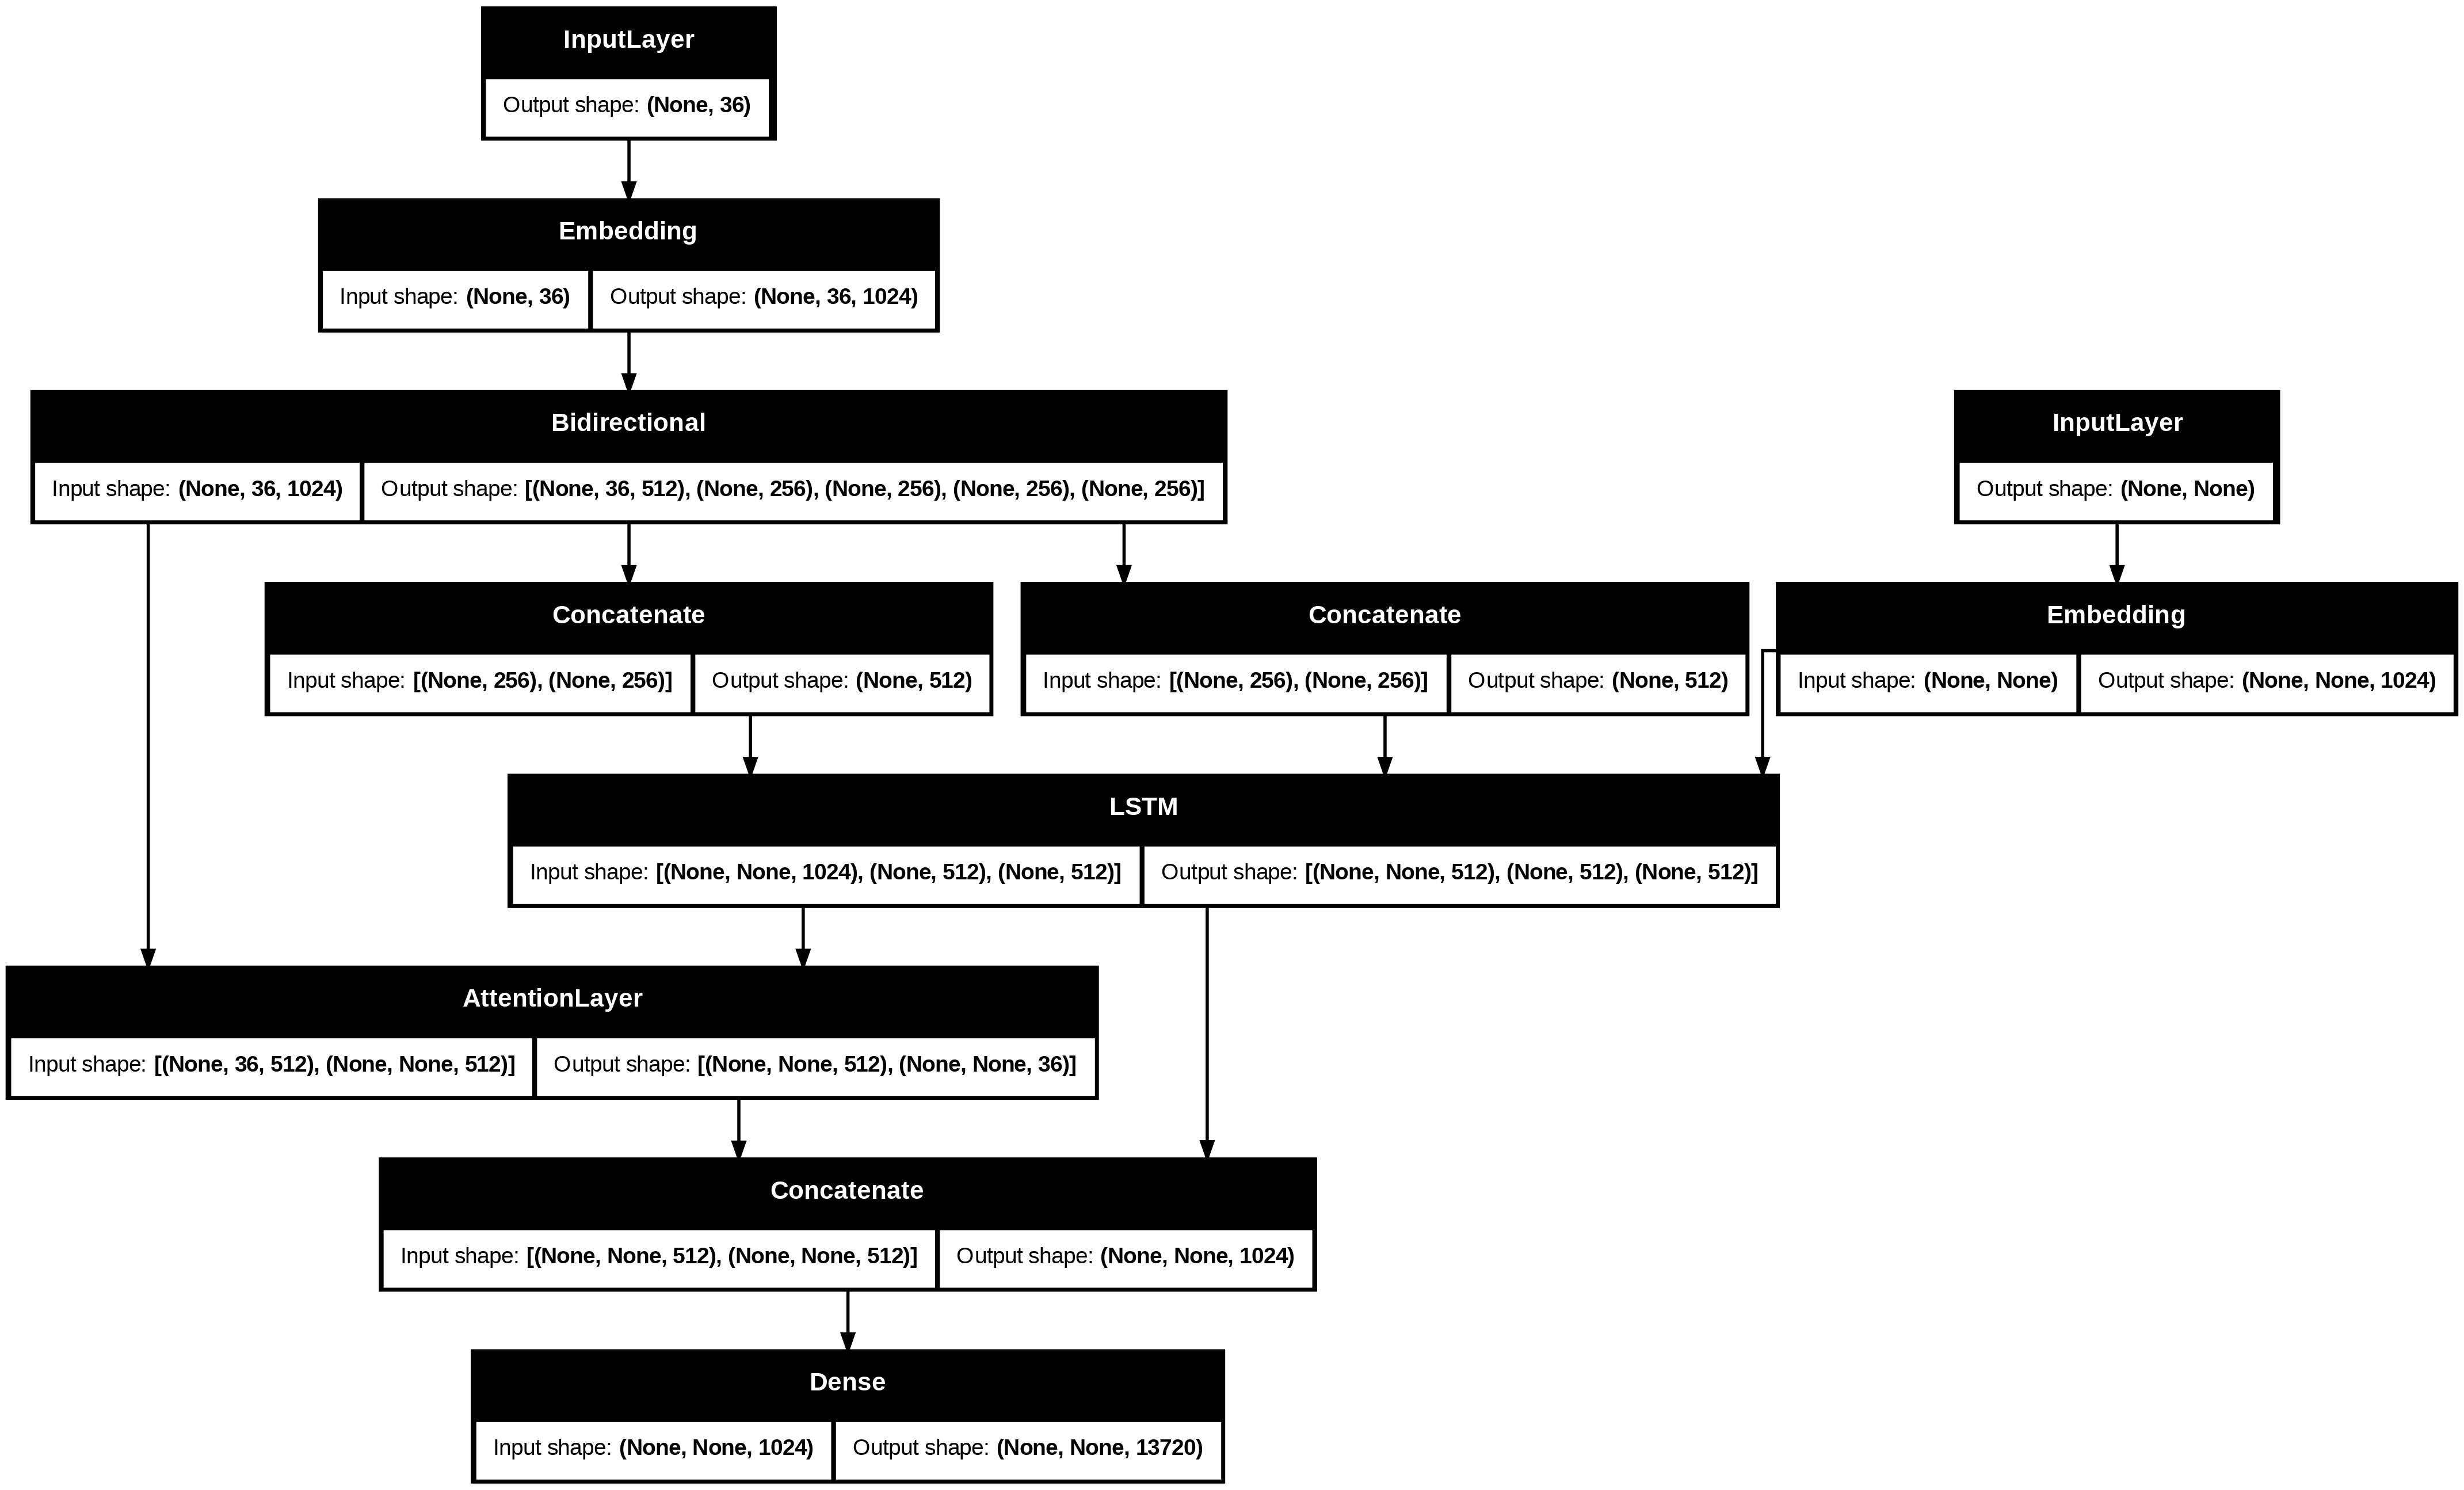

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

***IMP note :- if loss categorical crossentropy used then shapes incompatible error will occcur beause we have to use sparse_categorical_crossentropy when we have all different labels categorical is for mutliclass labels***

In [ ]:
# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Define callbacks

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/model_checkpoints/model1.h5",
    monitor='val_accuracy'
)


early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

callbacks_list = [checkpoint, early_stopping]

In [ ]:
# Training
encoder_input_data = X_train
# To make same as target data skip last number which is just padding
decoder_input_data = y_train[:,:-1]
# Decoder target data has to be one step ahead so we are taking from 1 as told in keras docs
decoder_target_data =  y_train[:,1:]

# Testing
encoder_input_test = X_test
decoder_input_test = y_test[:,:-1]
decoder_target_test=  y_test[:,1:]

In [ ]:
EPOCHS= 20 #@param {type:'slider',min:10,max:100, step:10 }

In [ ]:
history = model.fit([encoder_input_data, decoder_input_data],decoder_target_data,
                    epochs=EPOCHS,
                    batch_size=128,
                    validation_data = ([encoder_input_test, decoder_input_test],decoder_target_test),
                    callbacks= callbacks_list)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['attention_layer_2/attention_weights'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.8465 - loss: 1.5166

289/289 ━━━━━━━━━━━━━━━━━━━━ 112s 368ms/step - accuracy: 0.8466 - loss: 1.5149 - val_accuracy: 0.8822 - val_loss: 0.8461
Epoch 2/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.8866 - loss: 0.7794

289/289 ━━━━━━━━━━━━━━━━━━━━ 134s 346ms/step - accuracy: 0.8866 - loss: 0.7793 - val_accuracy: 0.8983 - val_loss: 0.6669
Epoch 3/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9050 - loss: 0.5813

289/289 ━━━━━━━━━━━━━━━━━━━━ 148s 366ms/step - accuracy: 0.9050 - loss: 0.5812 - val_accuracy: 0.9139 - val_loss: 0.5323
Epoch 4/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9237 - loss: 0.4146

289/289 ━━━━━━━━━━━━━━━━━━━━ 139s 357ms/step - accuracy: 0.9237 - loss: 0.4146 - val_accuracy: 0.9260 - val_loss: 0.4438
Epoch 5/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9395 - loss: 0.2917

289/289 ━━━━━━━━━━━━━━━━━━━━ 141s 356ms/step - accuracy: 0.9395 - loss: 0.2917 - val_accuracy: 0.9345 - val_loss: 0.3874
Epoch 6/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9533 - loss: 0.2042

289/289 ━━━━━━━━━━━━━━━━━━━━ 144s 364ms/step - accuracy: 0.9533 - loss: 0.2042 - val_accuracy: 0.9397 - val_loss: 0.3564
Epoch 7/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9635 - loss: 0.1491

289/289 ━━━━━━━━━━━━━━━━━━━━ 139s 356ms/step - accuracy: 0.9635 - loss: 0.1491 - val_accuracy: 0.9431 - val_loss: 0.3415
Epoch 8/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9707 - loss: 0.1137

289/289 ━━━━━━━━━━━━━━━━━━━━ 145s 365ms/step - accuracy: 0.9707 - loss: 0.1137 - val_accuracy: 0.9458 - val_loss: 0.3307
Epoch 9/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9758 - loss: 0.0902

289/289 ━━━━━━━━━━━━━━━━━━━━ 141s 361ms/step - accuracy: 0.9758 - loss: 0.0902 - val_accuracy: 0.9468 - val_loss: 0.3266
Epoch 10/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9790 - loss: 0.0745

289/289 ━━━━━━━━━━━━━━━━━━━━ 140s 355ms/step - accuracy: 0.9790 - loss: 0.0745 - val_accuracy: 0.9481 - val_loss: 0.3244
Epoch 11/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9814 - loss: 0.0635

289/289 ━━━━━━━━━━━━━━━━━━━━ 104s 359ms/step - accuracy: 0.9814 - loss: 0.0635 - val_accuracy: 0.9486 - val_loss: 0.3263
Epoch 12/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9830 - loss: 0.0559

289/289 ━━━━━━━━━━━━━━━━━━━━ 141s 355ms/step - accuracy: 0.9830 - loss: 0.0560 - val_accuracy: 0.9489 - val_loss: 0.3257
Epoch 13/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9843 - loss: 0.0497

289/289 ━━━━━━━━━━━━━━━━━━━━ 142s 355ms/step - accuracy: 0.9843 - loss: 0.0497 - val_accuracy: 0.9493 - val_loss: 0.3282
Epoch 14/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9851 - loss: 0.0463

289/289 ━━━━━━━━━━━━━━━━━━━━ 139s 346ms/step - accuracy: 0.9851 - loss: 0.0463 - val_accuracy: 0.9494 - val_loss: 0.3299
Epoch 15/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9859 - loss: 0.0426

289/289 ━━━━━━━━━━━━━━━━━━━━ 147s 364ms/step - accuracy: 0.9859 - loss: 0.0427 - val_accuracy: 0.9488 - val_loss: 0.3309
Epoch 16/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9865 - loss: 0.0404

289/289 ━━━━━━━━━━━━━━━━━━━━ 144s 370ms/step - accuracy: 0.9865 - loss: 0.0404 - val_accuracy: 0.9496 - val_loss: 0.3338
Epoch 17/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9867 - loss: 0.0386

289/289 ━━━━━━━━━━━━━━━━━━━━ 104s 360ms/step - accuracy: 0.9867 - loss: 0.0386 - val_accuracy: 0.9488 - val_loss: 0.3342
Epoch 18/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9868 - loss: 0.0374

289/289 ━━━━━━━━━━━━━━━━━━━━ 103s 356ms/step - accuracy: 0.9868 - loss: 0.0374 - val_accuracy: 0.9495 - val_loss: 0.3362
Epoch 19/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9871 - loss: 0.0362

289/289 ━━━━━━━━━━━━━━━━━━━━ 143s 360ms/step - accuracy: 0.9871 - loss: 0.0362 - val_accuracy: 0.9488 - val_loss: 0.3391
Epoch 20/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9874 - loss: 0.0354

289/289 ━━━━━━━━━━━━━━━━━━━━ 139s 349ms/step - accuracy: 0.9874 - loss: 0.0354 - val_accuracy: 0.9492 - val_loss: 0.3405


In [ ]:
import os

save_dir = "/content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/saved_model"
os.makedirs(save_dir, exist_ok=True)

model.save_weights(f"{save_dir}/model1.weights.h5")


#### Saving weights is very important if ypu dont after colab session ends you might have to retrain model

In [ ]:
model.save_weights("/content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/saved_model/model1.weights.h5")


#### After saving weight you can restart colab session without GPU
Create model and
load model

In [ ]:
model.load_weights("/content/drive/MyDrive/ML/rnn/Machine_Translation/Attention/saved_model/model1.weights.h5")


## Inference model
* For prediction we have to do this was because we trained encoder on input and decoder on target differently so we'll have to do same for prediction

In [ ]:
encoder_model = Model(encoder_inputs, outputs = [encoder_outputs1, final_enc_h, final_enc_c])

decoder_state_h = Input(shape=(512,))
decoder_state_c = Input(shape=(512,))
decoder_hidden_state_input = Input(shape=(36,512))

dec_states = [decoder_state_h, decoder_state_c]

dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=dec_states)

# Attention inference
attention_result_inf, attention_weights_inf = attention_layer([decoder_hidden_state_input, decoder_outputs2])

decoder_concat_input_inf = Concatenate(axis=-1, name='concat_layer')([decoder_outputs2, attention_result_inf])

dec_states2= [state_h2, state_c2]

decoder_outputs2 = decoder_dense(decoder_concat_input_inf)

decoder_model= Model(
                    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_h, decoder_state_c],
                     [decoder_outputs2]+ dec_states2)

### Model will predict numbers and word at time so we'll have to convert them to words of language

In [ ]:
def get_predicted_sentence(input_seq):
    # Encode the input as state vectors.
    enc_output, enc_h, enc_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = mar_word_index['sos']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [enc_output, enc_h, enc_c ])
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 0:
          break
        else:
            # convert max index number to marathi word
            sampled_char = mar_index_word[sampled_token_index]

        if (sampled_char!='end'):
            # aapend it ti decoded sent
            decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length or find stop token.
        if (sampled_char == 'eos' or len(decoded_sentence.split()) >= 36):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        enc_h, enc_c = h, c

    return decoded_sentence

## Converting x and y back to words-sentences

In [ ]:
def get_marathi_sentence(input_sequence):
    sentence =''
    for i in input_sequence:
      if i!=0 :
        sentence =sentence +mar_index_word[i]+' '
    return sentence

def get_english_sentence(input_sequence):
    sentence =''
    for i in input_sequence:
      if i!=0:
        sentence =sentence +eng_index_word[i]+' '
    return sentence

# Model results

In [ ]:
len(X_test)

4103

#### Using simple loop we will take random 15 numbers from x_test and get results


In [ ]:
for i in np.random.randint(10, 1000, size=15):
  print("English Sentence:",get_english_sentence(X_test[i]))
  print("Actual Marathi Sentence:",get_marathi_sentence(y_test[i])[4:-4])
  # Before passing input it has to be reshape as following
  print("Predicted Marathi Translation:",get_predicted_sentence(X_test[i].reshape(1,36))[:-4])
  print("----------------------------------------------------------------------------------------")

English Sentence: i sleep with the lights on 
Actual Marathi Sentence: मी लाईट चालू ठेवून झोपतो 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Marathi Translation:  मी दिवे चालू ठेवून झोपते
----------------------------------------------------------------------------------------
English Sentence: there was not much traffic this morning 
Actual Marathi Sentence: आज सकाळी जास्त ट्रॅफिक नव्हता 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted Marathi Translation:  आज सकाळी जास्त वारा नव्हता
-------------------------------------------------